[View in Colaboratory](https://colab.research.google.com/github/nikolay-bushkov/kaist_internship/blob/master/active_learning_for_sentiment_classification.ipynb)

# Predicting sentiment on the IMDB dataset

Based on https://developers.google.com/machine-learning/guides/text-classification/

In [0]:
!pip3 install -q modAL

In [0]:
import os
import tarfile

In [0]:
import numpy as np
from sklearn.datasets import load_files
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

## Data preparation

In [0]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2018-08-21 14:42:48--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  3.83MB/s    in 41s     

2018-08-21 14:43:29 (1.97 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
if not os.path.exists('aclImdb'):
    # unzip data if it does not exist
    with tarfile.open('aclImdb_v1.tar.gz', 'r:gz') as f:
        f.extractall()

In [0]:
train_ds = load_files('aclImdb/train/', categories=['pos', 'neg'])

In [0]:
test_ds = load_files('aclImdb/test/', categories=['pos', 'neg'])

In [0]:
X_train_full, y_train_full = np.asarray([x.decode() for x in train_ds['data']]).reshape(-1, 1), train_ds['target']

In [0]:
X_test, y_test = np.asarray([x.decode() for x in test_ds['data']]).reshape(-1, 1), test_ds['target']

We mostly leave the data as is; for better results, we should for instance remove markup, but we leave this out for brevity.

### A peak at the data

In [0]:
for text, target in zip(X_train_full[5:7], y_train_full[5:7]):
    print("Target: {}".format(train_ds['target_names'][target]))
    print(text)

Target: pos
["The Movie was sub-par, but this Television Pilot delivers a great springboard into what has become a Sci-Fi fans Ideal program. The Actors deliver and the special effects (for a television series) are spectacular. Having an intelligent interesting script doesn't hurt either.<br /><br />Stargate SG1 is currently one of my favorite programs."]
Target: pos
["This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending."]


## Baseline

In [0]:
def modAL_workaround(X):
    """Picklable function"""
    return X.reshape(-1)

In [0]:
steps = [
    ('modAL_workaround', FunctionTransformer(func=modAL_workaround)),
    ('featurizator', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('feature_selector', SelectKBest(f_classif, k=20000)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(32, 32),
                          alpha=0.01,
                          # unfortunately, sklearn implementation doesn't allow to dropout neurons, so set this
                          batch_size=128,
                          max_iter=1000,
                          early_stopping=True))
]

In [0]:
pipe = Pipeline(steps)

In [0]:
pipe.set_params(mlp__verbose=True, mlp__max_iter=2)

Pipeline(memory=None,
     steps=[('modAL_workaround', FunctionTransformer(accept_sparse=False,
          func=<function modAL_workaround at 0x7f8d331d16a8>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=True)), ('featurizator', TfidfVectorizer(analyzer='word', binary=Fal...e=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False))])

In [0]:
%time pipe.fit(X_train_full, y_train_full)

Iteration 1, loss = 0.50455488
Validation score: 0.908000
Iteration 2, loss = 0.21559817
Validation score: 0.928000
CPU times: user 24.8 s, sys: 17.1 s, total: 41.9 s
Wall time: 17.8 s


/home/nab/PycharmProjects/work/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
     steps=[('modAL_workaround', FunctionTransformer(accept_sparse=False,
          func=<function modAL_workaround at 0x7f8d331d16a8>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=True)), ('featurizator', TfidfVectorizer(analyzer='word', binary=Fal...e=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False))])

In [0]:
pipe.score(X_train_full, y_train_full)

0.95924

In [0]:
pipe.score(X_test, y_test)

0.89056

https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/integration_test.py#L23

## Active learning part

In [0]:
from modAL.models import ActiveLearner

In [0]:
import matplotlib.pyplot as plt

In [0]:
def random_sampling(classifier, X_pool, n_instances=1, **uncertainty_measure_kwargs):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples), size=n_instances)
    return query_idx, X_pool[query_idx]

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_seed, X_pool, y_seed, y_pool = train_test_split(X_full_train, y_full_train, train_size=1000, random_state=42)

/home/nab/PycharmProjects/work/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [0]:
pipe.set_params(mlp__verbose=False, mlp__max_iter=1000)

Pipeline(memory=None,
     steps=[('modAL_workaround', FunctionTransformer(accept_sparse=False,
          func=<function modAL_workaround at 0x7f8d331d16a8>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=True)), ('featurizator', TfidfVectorizer(analyzer='word', binary=Fal...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

In [0]:
active_learner = ActiveLearner(
    estimator=Pipeline(steps),
    X_training=X_seed, y_training=y_seed
)

In [0]:
active_learner.score(X_test, y_test)

0.5

In [0]:
passive_learner = ActiveLearner(
    estimator=Pipeline(steps),
    query_strategy=random_sampling,
    X_training=X_seed, y_training=y_seed
)

In [0]:
passive_learner.score(X_test, y_test)

0.7506

In [0]:
active_scores = list()
passive_scores = list()

In [0]:
X_pool_a, X_pool_p, y_pool_a, y_pool_p = X_pool[:], X_pool[:], y_pool[:], y_pool[:]

In [0]:
for query_step in range(1, 240 + 1):
    
    #active learner step
    query_idx_a, query_inst_a = active_learner.query(X_pool_a, n_instances=100)
    active_learner.teach(query_inst_a, y_pool_a[query_idx_a])
    X_pool_a, y_pool_a = np.delete(X_pool_a, query_idx_a, axis=0), np.delete(y_pool_a, query_idx_a)
    active_scores.append(active_learner.score(X_test, y_test))
    
    #passive learer step
    query_idx_p, query_inst_p = passive_learner.query(X_pool_p, n_instances=100)
    passive_learner.teach(query_inst_p, y_pool_p[query_idx_p])
    X_pool_p, y_pool_p = np.delete(X_pool_p, query_idx_p, axis=0), np.delete(y_pool_p, query_idx_p)
    passive_scores.append(passive_learner.score(X_test, y_test))

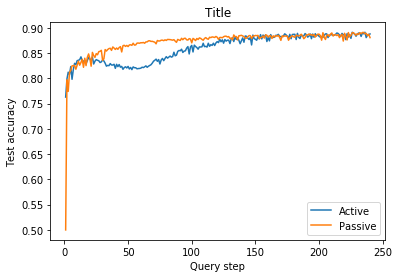

In [0]:
plt.plot(range(1, 240 + 1), active_scores, label='Active')
plt.plot(range(1, 240 + 1), passive_scores, label='Passive')
plt.title('Title')
plt.xlabel('Query step')
plt.ylabel('Test accuracy')
plt.legend()

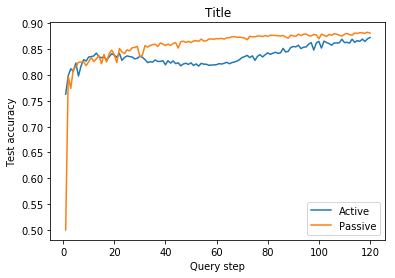

In [0]:
plt.plot(range(1, 120 + 1), active_scores[:120], label='Active')
plt.plot(range(1, 120 + 1), passive_scores[:120], label='Passive')
plt.title('Title')
plt.xlabel('Query step')
plt.ylabel('Test accuracy')
plt.legend()

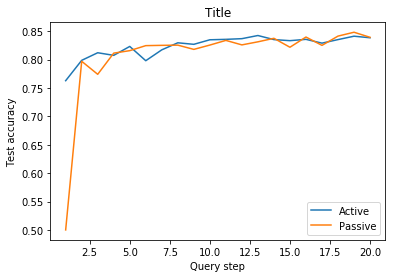

In [0]:
plt.plot(range(1, 20 + 1), active_scores[:20], label='Active')
plt.plot(range(1, 20 + 1), passive_scores[:20], label='Passive')
plt.title('Title')
plt.xlabel('Query step')
plt.ylabel('Test accuracy')
plt.legend()